In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import os
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import zipfile
import os
from google.colab import files


import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
# Upload dataset from local machine
uploaded = files.upload()

# Extract the uploaded zip file
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Verify extraction
os.listdir('dataset')

Saving train_ASD_DATA.zip to train_ASD_DATA.zip


['train_ASD_DATA']

In [3]:
# Upload dataset from local machine
uploaded = files.upload()

# Extract the uploaded zip file
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Verify extraction
os.listdir('dataset')

Saving test_ASD_DATA.zip to test_ASD_DATA.zip


['test', 'train_ASD_DATA']

In [4]:
# Upload dataset from local machine
uploaded = files.upload()

# Extract the uploaded zip file
zip_file = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Verify extraction
os.listdir('dataset')

Saving valid_ASD_DATA.zip to valid_ASD_DATA.zip


['test', 'train_ASD_DATA', 'valid']

In [5]:
train_asd_dir = '/content/dataset/train_ASD_DATA/train/Autistic'
train_nasd_dir ='/content/dataset/train_ASD_DATA/train/Non_Autistic'
validation_asd_dir ='/content/dataset/valid/Autistic'
validation_nasd_dir ='/content/dataset/valid/Non_Autistic'
test_asd_dir = '/content/dataset/test/Autistic'
test_nasd_dir = '/content/dataset/test/Non_Autistic'

In [6]:

# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_asd_fnames = os.listdir( train_asd_dir )
train_nasd_fnames = os.listdir( train_nasd_dir )


next_asd_pix = [os.path.join(train_asd_dir, fname)
                for fname in train_asd_fnames[ pic_index-8:pic_index]
               ]

next_nasd_pix = [os.path.join(train_nasd_dir, fname)
                for fname in train_nasd_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_asd_pix+next_nasd_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

# Define data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# DenseNet201 expects input shape of (224, 224, 3)
img_size = (224, 224)
batch_size = 10

# Training Set
train_set = train_datagen.flow_from_directory(
    '/content/dataset/train_ASD_DATA/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Validation Set
valid_set = valid_datagen.flow_from_directory(
    '/content/dataset/valid',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Test Set
test_set = test_datagen.flow_from_directory(
    '/content/dataset/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2526 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

74836368/74836368 [==============================] - 1s 0us/step


In [9]:

#To set the layers to non-trainable (weights will not be updated)
for layer in base_model.layers:
    layer.trainable = False

In [10]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import optimizers

# Assuming base_model is already defined as DenseNet201

# Add a global average pooling layer
x = layers.GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for binary classification output
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the full model
model = tf.keras.models.Model(base_model.input, outputs)

# Define the learning rate
learning_rate = 0.0001

# Compile the model with the Adam optimizer and learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers

# Define the base model using DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=outputs)

# Define the learning rate
learning_rate = 0.0001

# Compile the model with the Adam optimizer and learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Record the start time
start_time = time.time()

# Train the model
inc_best = model.fit(
    train_set,
    validation_data=valid_set,
    steps_per_epoch=158,
    epochs=100,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10),
        ModelCheckpoint(filepath='/content/gdrive/MyDrive/DNN Keras Models/densenet201_best_model.h5', save_best_only=True)
    ]
)

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time

# Convert training time to hours, minutes, and seconds
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Training completed in: {int(hours):0>2}:{int(minutes):0>2}:{seconds:05.2f}")
print(f"Total training time in seconds: {training_time:.2f}")

# To discover the training epoch on which training was stopped
final_epoch = len(inc_best.history['loss'])
print(f"Training stopped at epoch: {final_epoch}")

Epoch 1/100
158/158 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.6589

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


158/158 [==============================] - 50s 194ms/step - loss: 0.6162 - accuracy: 0.6589 - val_loss: 0.4593 - val_accuracy: 0.7875
Epoch 2/100
158/158 [==============================] - 26s 167ms/step - loss: 0.5198 - accuracy: 0.7437 - val_loss: 0.4017 - val_accuracy: 0.8125
Epoch 3/100
158/158 [==============================] - 27s 169ms/step - loss: 0.4793 - accuracy: 0.7646 - val_loss: 0.3456 - val_accuracy: 0.8500
Epoch 4/100
158/158 [==============================] - 26s 166ms/step - loss: 0.4812 - accuracy: 0.7715 - val_loss: 0.3362 - val_accuracy: 0.8500
Epoch 5/100
158/158 [==============================] - 30s 189ms/step - loss: 0.4605 - accuracy: 0.7862 - val_loss: 0.3146 - val_accuracy: 0.8375
Epoch 6/100
158/158 [==============================] - 27s 168ms/step - loss: 0.4368 - accuracy: 0.8025 - val_loss: 0.3118 - val_accuracy: 0.8625
Epoch 7/100
158/158 [==============================] - 25s 160ms/step - loss: 0.4340 - accuracy: 0.7887 - val_loss: 0.3253 - val_accurac

In [13]:
model.save('/content/dataset/Model/densenet201_best_model.h5')

In [14]:
#model for plotting
dense = model.fit(train_set, validation_data = valid_set, steps_per_epoch = 100, epochs = 100)

Epoch 1/100
100/100 [==============================] - 16s 159ms/step - loss: 0.1816 - accuracy: 0.9388 - val_loss: 0.1657 - val_accuracy: 0.9375
Epoch 2/100
100/100 [==============================] - 17s 173ms/step - loss: 0.1894 - accuracy: 0.9260 - val_loss: 0.1684 - val_accuracy: 0.9500
Epoch 3/100
100/100 [==============================] - 16s 161ms/step - loss: 0.1948 - accuracy: 0.9180 - val_loss: 0.1658 - val_accuracy: 0.9375
Epoch 4/100
100/100 [==============================] - 16s 157ms/step - loss: 0.1975 - accuracy: 0.9247 - val_loss: 0.1481 - val_accuracy: 0.9625
Epoch 5/100
100/100 [==============================] - 17s 170ms/step - loss: 0.1939 - accuracy: 0.9150 - val_loss: 0.1428 - val_accuracy: 0.9500
Epoch 6/100
100/100 [==============================] - 16s 159ms/step - loss: 0.1875 - accuracy: 0.9307 - val_loss: 0.1348 - val_accuracy: 0.9500
Epoch 7/100
100/100 [==============================] - 17s 165ms/step - loss: 0.1907 - accuracy: 0.9310 - val_loss: 0.1471 -

In [15]:
model.save('/content/dataset/Model/densenet201_100.h5')

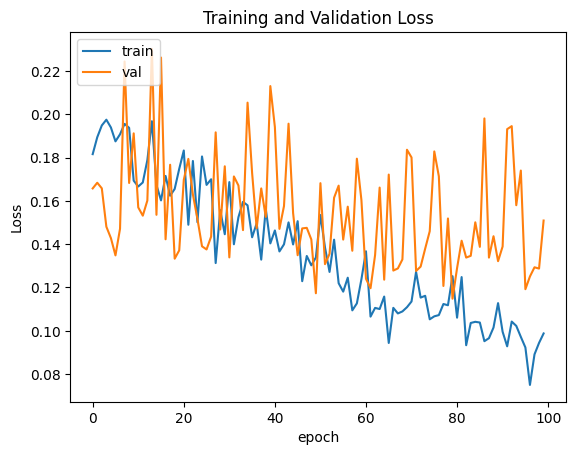

In [16]:
import keras
from matplotlib import pyplot as plt


plt.plot(dense.history['loss'])
plt.plot(dense.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

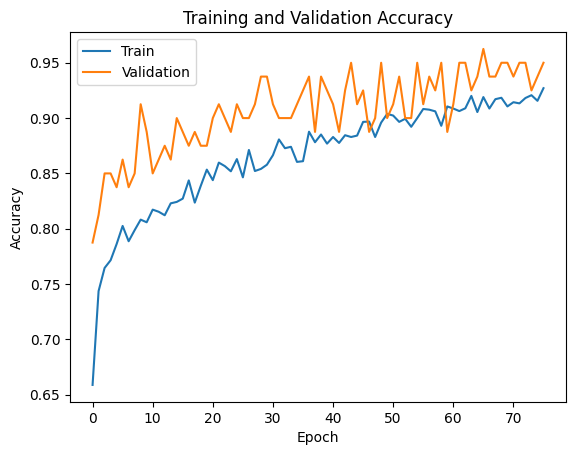

In [17]:
import matplotlib.pyplot as plt

# Assuming `inc_best` is the history object returned by `model.fit`
history = inc_best.history

# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:

from tensorflow.keras.models import load_model
model = load_model('/content/dataset/Model/densenet201_100.h5')

1/1 [==============================] - 6s 6s/step


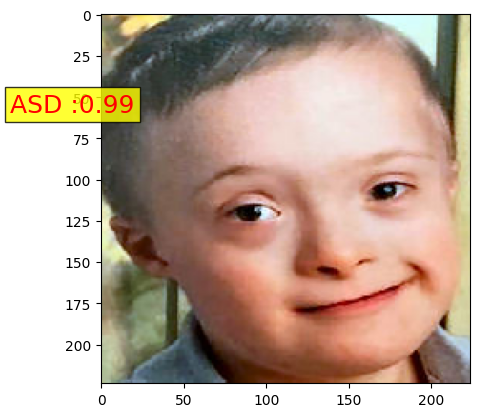

In [19]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('/content/dataset/test/Autistic/ta.014.jpg', target_size=(224, 224))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='NASD :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='yellow',alpha=0.8))
else:
    value ='ASD :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,horizontalalignment='right',
        verticalalignment='bottom',bbox=dict(facecolor='yellow',alpha=0.8))

plt.imshow(img1)
plt.show()

1/1 [==============================] - 0s 36ms/step


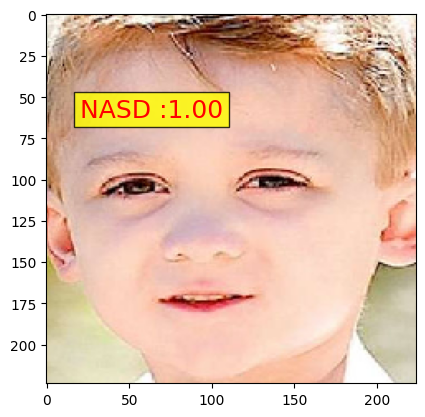

In [20]:

#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('/content/dataset/test/Non_Autistic/tna.005.jpg', target_size=(224, 224))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='NASD :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='yellow',alpha=0.8))
else:
    value ='ASD :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,horizontalalignment='right',
        verticalalignment='bottom',bbox=dict(facecolor='yellow',alpha=0.8))

plt.imshow(img1)
plt.show()

In [21]:
import pandas as pd
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reset the test set (if needed)
test_set.reset()

# Measure inference time
start_inference_time = time.time()
ytesthat = model.predict_generator(test_set)
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time

print(f"Inference time: {inference_time} seconds")

# Create a DataFrame to store the results
df = pd.DataFrame({
    'filename': test_set.filenames,
    'predict': ytesthat[:, 0],
    'y': test_set.classes
})

# Convert the predicted probabilities to binary predictions
y_pred_binary = (ytesthat > 0.5).astype(int)

# Get the true labels from the test set
y_true = test_set.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)

# Calculate precision
precision = precision_score(y_true, y_pred_binary)

# Calculate recall
recall = recall_score(y_true, y_pred_binary)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary)

# Print the metrics
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


<ipython-input-21-f4f588b33b4c>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  ytesthat = model.predict_generator(test_set)


Inference time: 4.670646905899048 seconds
Test Accuracy: 0.9392857142857143
Precision: 0.9767441860465116
Recall: 0.9
F1 Score: 0.9368029739776953


In [22]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)

In [23]:

misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 280 Testing images : %d'%misclassified['y'].count())


Total misclassified image from 280 Testing images : 17


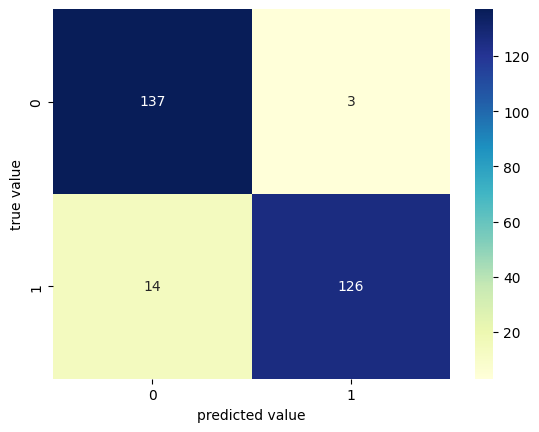

In [24]:
#Prediction of test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [25]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

#Training Set
train_set = train_datagen.flow_from_directory('/content/dataset/train_ASD_DATA/train',
                                             target_size=(224,224),
                                             batch_size=10,
                                              shuffle=False,
                                             class_mode='binary')

Found 2526 images belonging to 2 classes.


In [26]:

import pandas as pd
train_set.reset
ytrainhat = model.predict_generator(train_set)
df = pd.DataFrame({
    'filename':train_set.filenames,
    'predict':ytrainhat[:,0],
    'y':train_set.classes
})

<ipython-input-26-86d4ed593533>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  ytrainhat = model.predict_generator(train_set)


In [27]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)

In [28]:

misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 2526 Training images : %d'%misclassified['y'].count())

Total misclassified image from 2526 Training images : 308


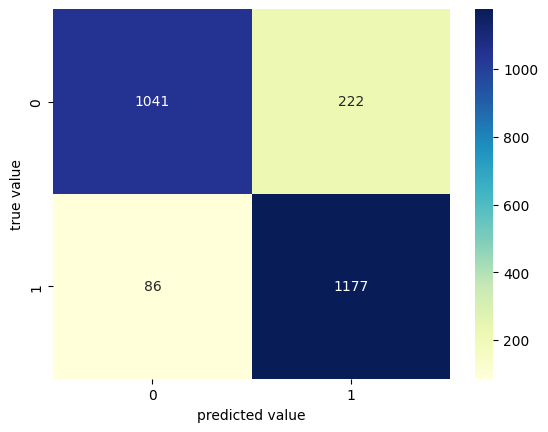

In [29]:

#Prediction of test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [30]:

import pandas as pd
valid_set.reset
yvalidhat = model.predict_generator(valid_set)
df = pd.DataFrame({
    'filename':valid_set.filenames,
    'predict':yvalidhat[:,0],
    'y':valid_set.classes
})


<ipython-input-30-853db96b44e2>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yvalidhat = model.predict_generator(valid_set)


In [31]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)

In [32]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 80 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 80 Validation images : 3


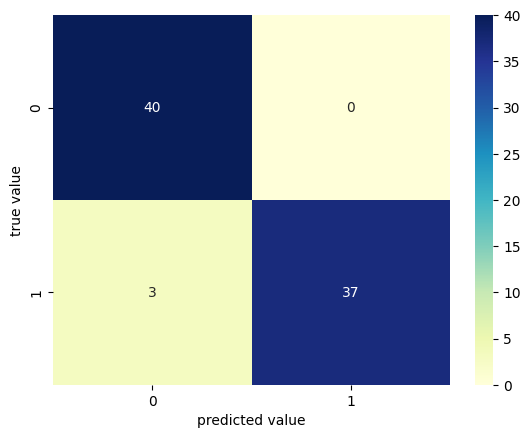

In [33]:

#Prediction of test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');